In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import math
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
data=pd.read_csv('C:/Users/ARSHTVIK/Downloads/datasets/KOTAKBANK_data.csv')

In [3]:
data.head()

,Date,open,high,low,close,adj_close,volume
0,2001-07-02,2.4025,2.4750,2.4000,2.4025,0.526914,110800.0
1,2001-07-03,2.4750,2.4750,2.3750,2.4000,0.526366,77520.0
2,2001-07-04,2.4250,2.4500,2.3875,2.4200,0.530752,49360.0
3,2001-07-05,2.4500,2.4725,2.4000,2.4150,0.529656,62700.0
4,2001-07-06,2.4250,2.4250,2.3500,2.4000,0.526366,117800.0


In [4]:
data.isnull().any()

Date         False
open          True
high          True
low           True
close         True
adj_close     True
volume        True
dtype: bool

In [5]:
data.dropna(inplace=True)
data.isnull().any()

Date         False
open         False
high         False
low          False
close        False
adj_close    False
volume       False
dtype: bool

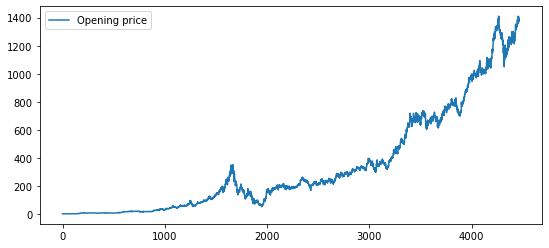

In [6]:
plt.figure(figsize=(9,4))
plt.plot(data['open'],label='Opening price')
plt.legend()
plt.show()

In [7]:
high=np.array(data['high'])
low=np.array(data['low'])
price=(high+low)/2

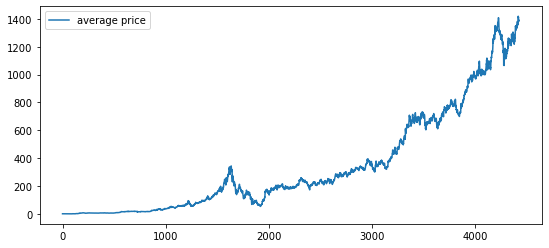

In [8]:
plt.figure(figsize=(9,4))
plt.plot(price,label='average price')
plt.legend()
plt.show()

In [9]:
train_perc=math.floor(data['high'].count()*0.9)
train_perc

3986

In [10]:
train_data=price[0:train_perc]
test_data=price[train_perc:]

In [11]:
sc=MinMaxScaler(feature_range=(0,1))
train_data=train_data.reshape(-1,1)
test_data=test_data.reshape(-1,1)
train_data=sc.fit_transform(train_data)
test_data=sc.fit_transform(test_data)

In [12]:
def create_dataset(data,shuffle=False):
    gen=TimeseriesGenerator(data,data,length=10,shuffle=False)
    X=[]
    Y=[]
    for i in range(len(gen)):
        a,b=gen[i]
        for j in range(a.shape[0]):
            X.append(a[j])
            Y.append(b[j])
    
    return np.array(X),np.array(Y)

In [13]:
X_train,Y_train=create_dataset(train_data)
X_test,Y_test=create_dataset(test_data)

In [14]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3976, 10, 1) (3976, 1)
(433, 10, 1) (433, 1)


In [15]:
X_train=X_train.reshape(-1,10)
X_test=X_test.reshape(-1,10)
Y_train=Y_train.reshape(-1,1)
Y_test=Y_test.reshape(-1,1)

In [16]:
xgmodel = xgb.XGBRegressor(objective='reg:squarederror',learning_rate=0.05,max_depth=15,n_estimators=200,verbose=False)

In [17]:
xgmodel.fit(X_train,Y_train)

[14:45:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbose=False,
             verbosity=None)

In [18]:
y_pred=xgmodel.predict(X_test)

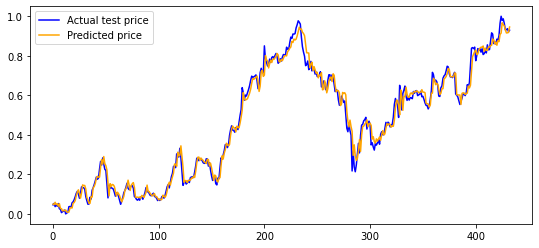

In [19]:
plt.figure(figsize=(9,4))
plt.plot(Y_test,label='Actual test price',color='blue')
plt.plot(y_pred,label='Predicted price',color='orange')
plt.legend()
plt.show()

In [20]:
def future_predict(data,model):
    output=[]
    for i in range(10):
        data=data[-10:]
        pred=model.predict(data.reshape(1,10))
        output.append(pred)
        data=np.concatenate([data,np.array(pred).reshape(-1,1)],axis=0)
    return output

In [21]:
average=sc.fit_transform(price.reshape(-1,1))

In [22]:
predictions=future_predict(average[-50:],xgmodel)

In [23]:
u=average[-100:]
v=np.concatenate([u,np.array(predictions)])

In [24]:
past_values=sc.inverse_transform(u)
future_values=sc.inverse_transform(v)

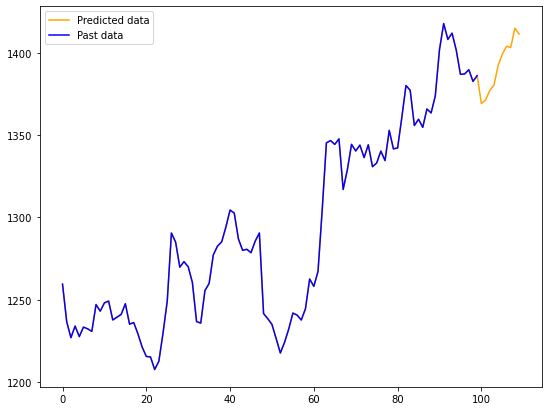

In [25]:
plt.figure(figsize=(9,7))
plt.plot(future_values,color='orange',label='Predicted data')
plt.plot(past_values,color='blue',label='Past data')
plt.legend()
plt.show()